In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plot_movies
%matplotlib inline
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
def get_team_members(teamname):
    return [name for name, teamnames in credits_by_teams if teamname in teamnames]

with open('movies_6feb2017.json','rb') as infile:
    movie_dicts = json.load(infile)    
    
title, budget, gross, studio, rating, num_ratings, release_year = [], [], [], [], [], [], []
special_effects, visual_effects, animators, writers = [], [], [], []
full_crew = []

for movie in movie_dicts:
    if movie["title"] and int(movie["release_year"]) > 1979:
        title.append(movie["title"])
        release_year.append(int(movie["release_year"]))
           
        if movie["production_co"]:
            movie["production_co"] = movie["production_co"].replace('\n','')            
            studio.append(movie["production_co"].encode('utf-8'))
        else:
            studio.append("None")

        if movie["rating"] is None:
            movie["rating"] = 0            
        rating.append(float(movie["rating"]))

        if movie["num_ratings"]:
            movie["num_ratings"] = int(movie["num_ratings"].replace(',',''))
        elif movie["num_ratings"] is None:
            movie["num_ratings"]=0
        num_ratings.append(movie["num_ratings"])
                           
        if movie["gross"] is None:
            movie["gross"] = 0
        else:
            movie["gross"] = movie["gross"].strip()
            movie["gross"] = movie["gross"].replace(',','')
            movie["gross"] = movie["gross"].replace('$','')
        gross.append(float(movie["gross"])/1000000)
        
        credits_by_teams = movie["credits_by_teams"]
        full_crew.append(credits_by_teams)
        writers.append(get_team_members("Writing Credits"))
        visual_effects.append(len(get_team_members("Visual Effects by")))
        animators.append(len(get_team_members("Animation Department")))

In [4]:
ratio = []
for idx, val in enumerate(animators):
    if val == 0:
        ratio.append(0)
    else:
        ratio.append(float(visual_effects[idx])/val)

In [5]:
movie_df = pd.DataFrame({'title': title, 'Studio': studio, 'rating': rating, 'num_ratings': num_ratings, 
                         'gross': gross, 'ratio': ratio, 'writers': writers})
index_by_gross = movie_df.set_index(["gross"])
top50 = index_by_gross.sort_index(ascending = False).head(50)
top50.index.name = None
top100 = index_by_gross.sort_index(ascending = False).head(100)
top100.index.name = None
studio_gross_df = pd.pivot_table(movie_df, values='gross', index=['Studio'], aggfunc=np.sum)
studio_gross_df = studio_gross_df[studio_gross_df > 1000]

In [6]:
studio_gross_df

Studio
DreamWorks Animation               3747.045253
Pixar Animation Studios            2885.427315
Twentieth Century Fox Animation    1032.948077
Universal Pictures                 1379.682960
Walt Disney Pictures               3944.117172
Name: gross, dtype: float64

In [7]:
pixar = top50[top50.Studio == "Pixar Animation Studios"]
disney = top100[top100.Studio == "Walt Disney Pictures"].head(11)
dreamworks = top100[(top100.Studio == "DreamWorks") | (top100.Studio == "DreamWorks Animation")].head(20)

In [8]:
allpixar = movie_df[movie_df.Studio == "Pixar Animation Studios"]
alldisney = movie_df[movie_df.Studio == "Walt Disney Pictures"]
alldreamworks = movie_df[(movie_df.Studio == "DreamWorks") | (movie_df.Studio == "DreamWorks Animation")]
#ax = allpixar.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
#                               alpha = 0.6)
#alldisney.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
#                          label='disney/pixar', alpha = 0.6, ax=ax)
#alldreamworks.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
#                              color='r', label='dreamworks', alpha = 0.7, ax=ax)
#plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
#plt.xticks(fontsize=13)
#plt.yticks(fontsize=13)
#plt.ylabel('IMDb Rating', fontsize=18)

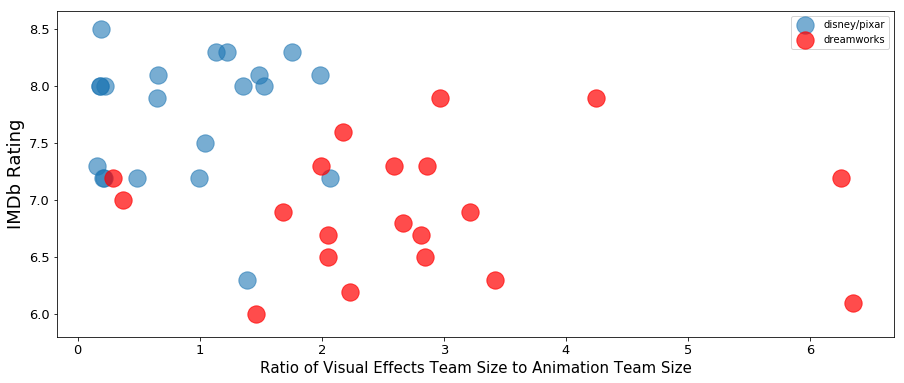

In [9]:
ax = pixar.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                               alpha = 0.6)
disney.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,  
                          label='disney/pixar', alpha = 0.6, ax=ax)
dreamworks.reset_index().plot(x="ratio", y='rating', figsize = (15,6), kind='scatter', marker='o', s=300,
                              color='r', label='dreamworks', alpha = 0.7, ax=ax)
plt.xlabel('Ratio of Visual Effects Team Size to Animation Team Size',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.ylabel('IMDb Rating', fontsize=18)

In [10]:
#top50.reset_index().plot(x="rating", y='num_ratings', figsize = (17,7), kind='scatter', marker='o', color='r')
#plt.xlabel('IMDb Rating',fontsize=15)
#plt.xlim([5.8 ,8.7])
#plt.ylabel('Number of IMDb Ratings', fontsize=18)

In [11]:
#show(plot_movies.make_interactive_plot())

In [12]:
#plot_movies.write_plot_html()

In [110]:
pixardisney_dict = {}

pixar_titles = pixar.title.tolist()
pixar_writers = pixar.writers.tolist()
pixar_dict = {}
for idx, title in enumerate(pixar_titles):
    pixar_dict[title.strip()] = [writer.strip() for writer in pixar_writers[idx]]
    pixardisney_dict[title.strip()] = [writer.strip() for writer in pixar_writers[idx]]
    
disney_titles = disney.title.tolist()
disney_writers = disney.writers.tolist()
disney_dict = {}
for idx, title in enumerate(disney_titles):
    disney_dict[title.strip()] = [writer.strip() for writer in disney_writers[idx]]
    pixardisney_dict[title.strip()] = [writer.strip() for writer in disney_writers[idx]]


dreamworks_titles = dreamworks.title.tolist()
dreamworks_writers = dreamworks.writers.tolist()
dreamworks_dict = {}
for idx, title in enumerate(dreamworks_titles):
    dreamworks_dict[title.strip()] = [writer.strip() for writer in dreamworks_writers[idx]]

In [16]:
import networkx as nx

In [103]:
def trim_degrees(g, degree=1):
    g2 = g.copy()
    d = nx.degree(g2)
    for node, data in g2.nodes(data=True):
        if d[node] <= degree and data['node_type'] == 'Writer':
            g2.remove_node(node)
    return g2

def get_colors(g):
    color_list =[]
    for node, data in g.nodes(data=True):
        if data['node_type'] == 'Movie':
            color_list.append('r')
        else:
            color_list.append('b')
    return color_list

def make_network_graph(movie_dict, degree_to_trim=1):
    G=nx.Graph()
    for title, writers_list in movie_dict.iteritems():
        G.add_node(title, node_type='Movie')
        for writer in writers_list:
            G.add_node(writer, node_type='Writer')
            G.add_edge(writer, title)
    G=trim_degrees(G, degree_to_trim)
    return G

In [97]:
G=make_network_graph(pixar_dict)
pos=nx.spring_layout(G, k=0.20, scale=1.0)

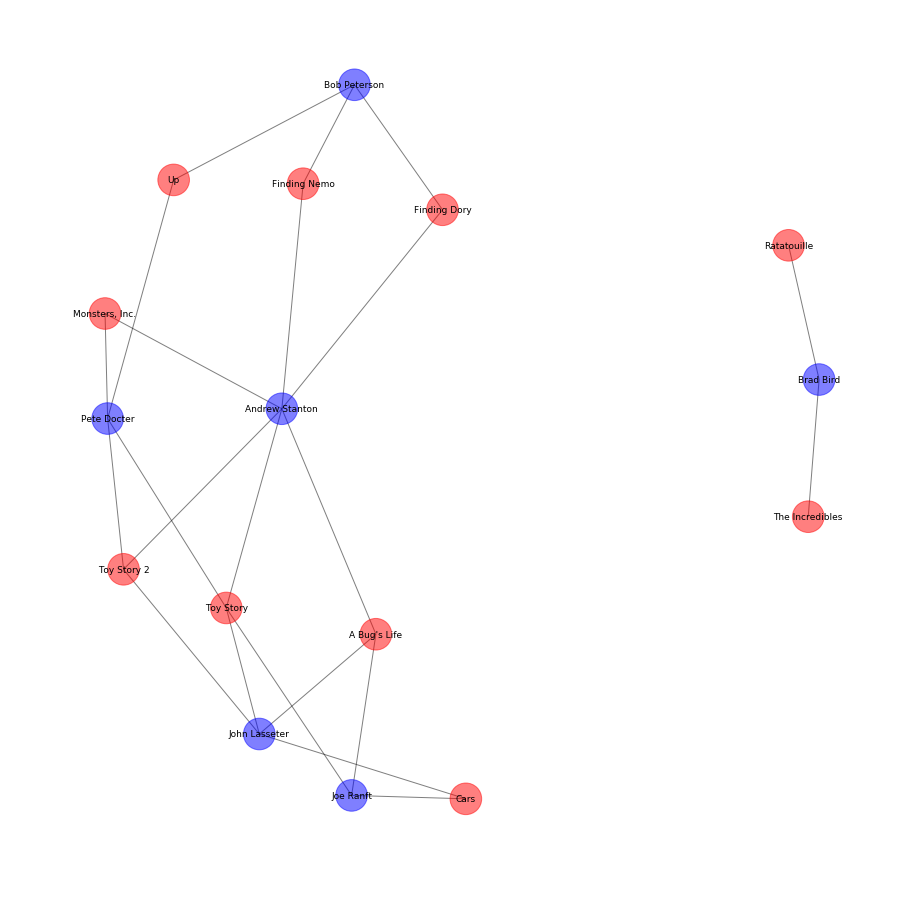

In [98]:
# larger figure size
plt.figure(3,figsize=(12,12)) 
nx.draw(G, pos, node_color=get_colors(G), node_size=1000, width=1,edge_cmap=plt.cm.Blues, font_size=9, alpha = 0.5,
        with_labels=True)


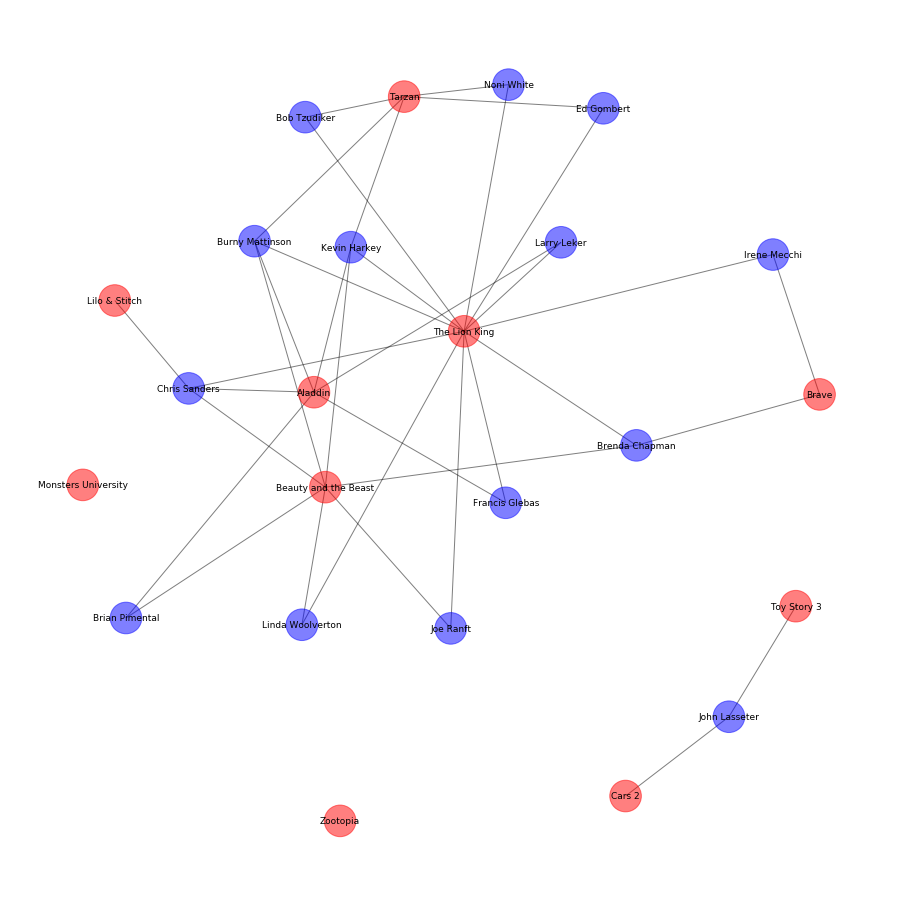

In [100]:
D=make_network_graph(disney_dict)
pos=nx.spring_layout(D)
plt.figure(3,figsize=(12,12)) 
nx.draw(D,pos,node_color=get_colors(D), node_size=1000, width=1,edge_cmap=plt.cm.Blues, 
        alpha=0.5, font_size=9, with_labels=True)

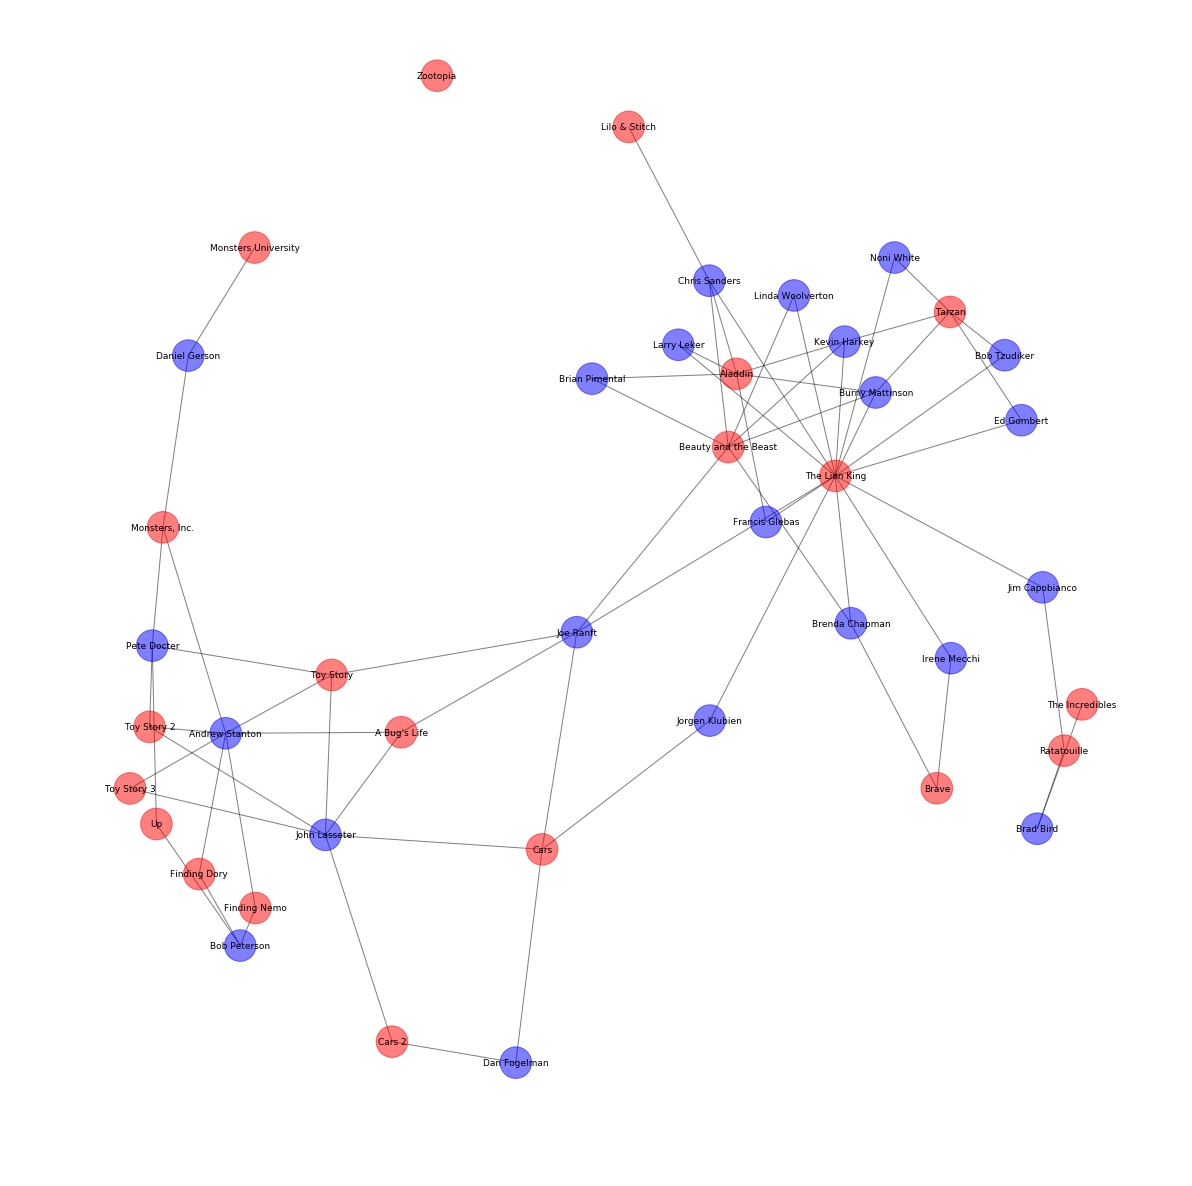

In [116]:
PD=make_network_graph(pixardisney_dict, degree_to_trim=1)
pos=nx.spring_layout(PD, k=0.1)
plt.figure(3,figsize=(16,16)) 
nx.draw(PD, pos,node_color=get_colors(PD), node_size=1000, width=1,edge_cmap=plt.cm.Blues, 
        alpha=0.5, font_size=9, with_labels=True)

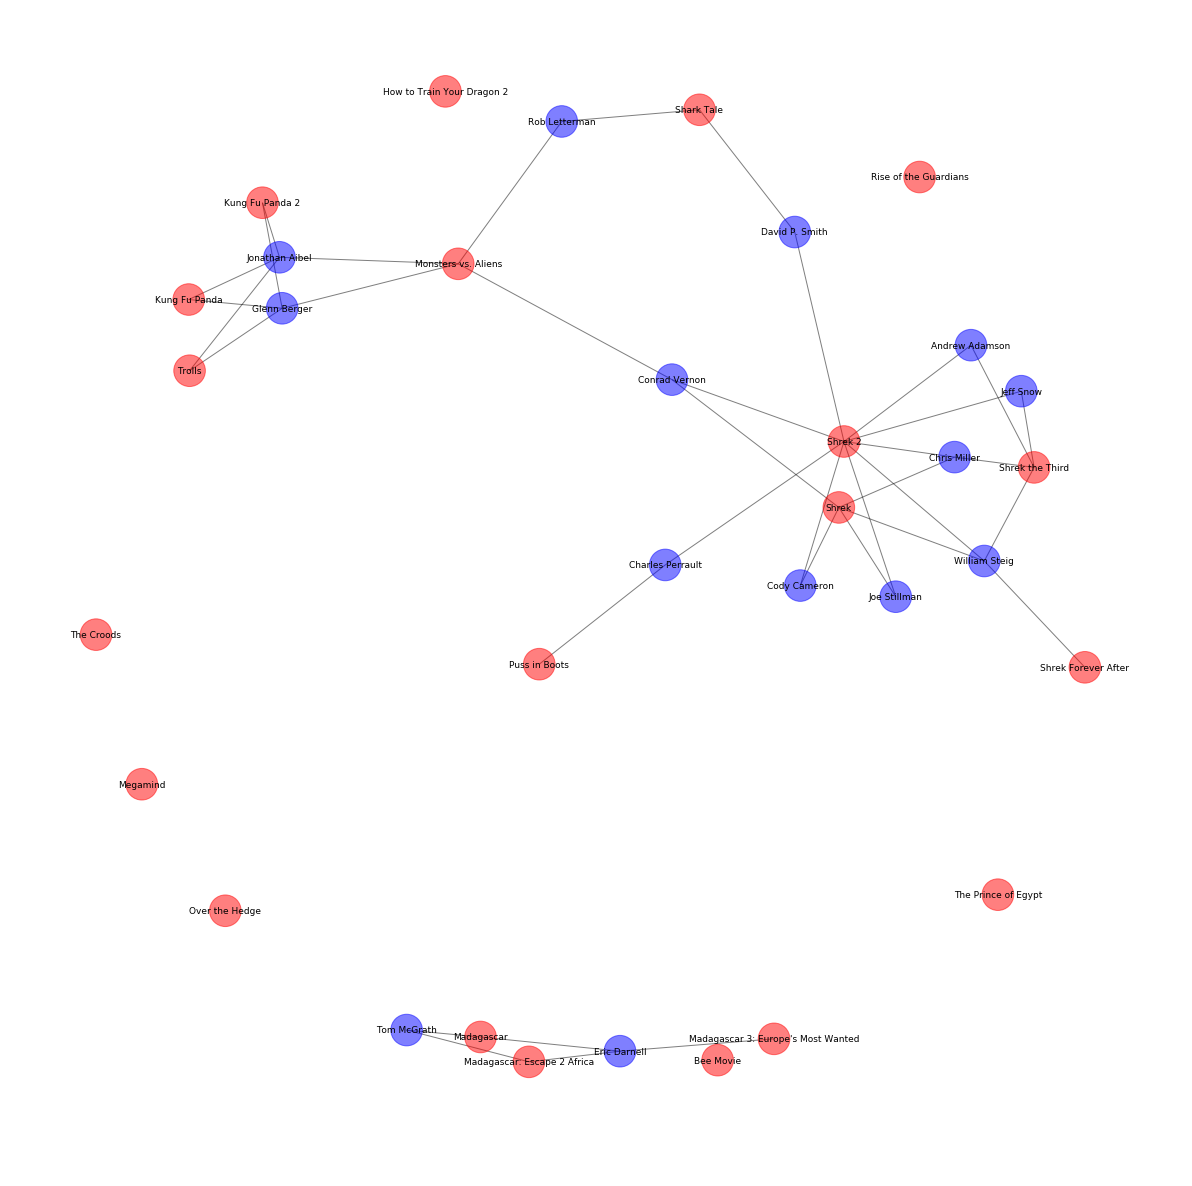

In [115]:
E=make_network_graph(dreamworks_dict, degree_to_trim=1)
pos=nx.spring_layout(E, k=0.1)
plt.figure(3,figsize=(16,16)) 
nx.draw(E,pos,node_color=get_colors(E), node_size=1000, width=1,edge_cmap=plt.cm.Blues, 
        alpha=0.5, font_size=9, with_labels=True)